In [1]:
import numpy as np
from hmmlearn import hmm
from hmmlearn.base import ConvergenceMonitor
import matplotlib.pyplot as plt
from matplotlib import colormaps
from static_probabilities import TRANSITION_PROBABILITIES_12UL, EMISSION_PROBABILITIES_12UL, START_PROBABILITIES_12UL
from time import time
from collections import Counter

# Fetching Data

In [2]:
from requests import get as _get

BASE_URL = 'http://localhost:8080'


def get(url: str) -> list:
    l = _get(f'{BASE_URL}/{url}').json()
    print(l[0])
    print(f'Fetched {len(l)} items')
    return l

In [4]:
detections = sorted(get('detection'), key=lambda x: x["timestamp"])

{'id': 3493712, 'batonId': 4, 'stationId': 2, 'rssi': -95, 'battery': 95.0, 'uptimeMs': 31684964, 'remoteId': 267237, 'timestamp': 1651071359251}
Fetched 2034655 items


In [5]:
batons = get('baton')

{'id': 2, 'name': 'O', 'mac': '5a:45:55:53:00:00'}
Fetched 22 items


In [6]:
baton_switchovers = sorted(get('batonswitchover'), key=lambda x: x["timestamp"])

{'id': 1, 'teamId': 1, 'previousBatonId': None, 'newBatonId': 23, 'timestamp': 1651012254359}
Fetched 73 items


In [7]:
stations = get('station')

{'id': 10, 'name': 'station 5', 'distanceFromStart': 219.0, 'isBroken': False, 'url': 'http://172.12.50.105:8000'}
Fetched 7 items


In [8]:
teams = get('team')

{'id': 1, 'name': 'HILOK', 'batonId': 18}
Fetched 17 items


In [9]:
laps = get('accepted-laps')

{'id': 5096, 'teamId': 7, 'lapSourceId': 1, 'timestamp': 1651039200000}
Fetched 740 items


# Processing data

In [71]:
team_detections: dict[int, list] = {team["id"]: [] for team in teams}
team_by_id: dict[int, dict] = {team["id"]: team for team in teams}
baton_team: dict[int, dict] = {}

switchover_index = 0
for detection in detections:
    while switchover_index < len(baton_switchovers) and baton_switchovers[switchover_index]["timestamp"] < detection[
        "timestamp"]:
        switchover = baton_switchovers[switchover_index]
        baton_team[switchover["newBatonId"]] = team_by_id[switchover["teamId"]]
        switchover_index += 1

    if detection["batonId"] in baton_team:
        if detection["rssi"] > -80:
            current_detections = team_detections[baton_team[detection["batonId"]]["id"]]
            if len(current_detections) > 0 and current_detections[-1]["timestamp"] == detection["timestamp"]:
                if current_detections[-1]["rssi"] < detection["rssi"]:
                    current_detections[-1] = detection
            else:
                current_detections.append(detection)

In [72]:
print({k: len(v) for k, v in team_detections.items()})

{1: 56741, 3: 39033, 4: 28140, 5: 49575, 8: 49237, 9: 34699, 10: 45604, 11: 37978, 12: 37402, 13: 36799, 14: 36516, 17: 23795, 7: 35834, 22: 34665, 6: 34690, 2: 31599, 16: 30999}


# Fitted Viterbi Lapper

## Fitting HMM parameters

In [86]:
station_to_emission = {v: k for k, v in enumerate([station["id"] for station in stations])}
data = [[[station_to_emission[detection["stationId"]]] for detection in team_detections[i]] for i in team_detections.keys()]
np_data = np.concatenate(data)
lengths = [len(x) for x in data]

transmat = np.array([
    [0.8, 0.1, 0., 0., 0., 0., 0.1],
    [0.1, 0.8, 0.1, 0., 0., 0., 0.],
    [0., 0.1, 0.8, 0.1, 0., 0., 0.],
    [0., 0., 0.1, 0.8, 0.1, 0., 0.],
    [0., 0., 0., 0.1, 0.8, 0.1, 0.],
    [0., 0., 0., 0., 0.1, 0.8, 0.1],
    [0.1, 0., 0., 0., 0., 0.1, 0.8]
])
emissionprob = np.array([
    [0.76, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.76, 0.04, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.76, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.76, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.76, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.04, 0.76, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.76],
])

model = hmm.CategoricalHMM(n_components=7, n_iter=1000, init_params="")
model.transmat_ = transmat.copy()  # TRANSITION_PROBABILITIES_12UL.copy()
model.emissionprob_ = EMISSION_PROBABILITIES_12UL.copy()
model.startprob_ = START_PROBABILITIES_12UL.copy()
model.monitor_ = ConvergenceMonitor(model.monitor_.tol, model.monitor_.n_iter, model.monitor_.verbose)

model.fit(np_data, lengths)
model.monitor_

ConvergenceMonitor(
    history=[-592026.4830907698, -469524.9973627721, -424028.2631410458, -348215.5391944783, -319952.8594438734, -319078.50089232775, -318913.9894791682, -318861.50221729884, -318833.80984839285, -318816.7666550386, -318805.8967175243, -318798.8796974054, -318794.31126768637, -318791.304776974, -318789.2938874269, -318787.91552413395, -318786.9351957237, -318786.2013099168, -318785.6207197315, -318785.1441788779, -318784.7483184894, -318784.4171704708, -318784.1369029254, -318783.8979845124, -318783.6943451484, -318783.52097606956, -318783.3728726317, -318783.2451656752, -318783.13352748135, -318783.0344003069, -318782.9450030063, -318782.8632180657, -318782.7874408635, -318782.7164477049, -318782.6492908243, -318782.5852246484, -318782.52365120914, -318782.46408456017, -318782.4061227108, -318782.3494288867, -318782.29371576285, -318782.2387352566, -318782.18427012995, -318782.1301265021, -318782.0761301334, -318782.02212269994, -318781.96795753716, -318781.9134987

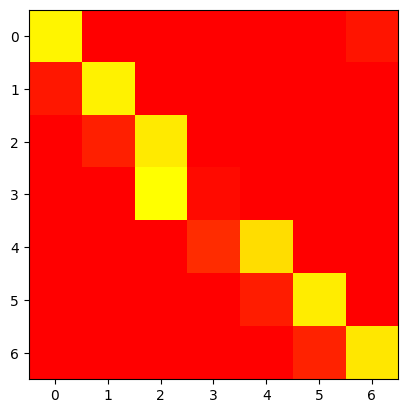

In [123]:
plt.imshow(model.transmat_, interpolation='none', cmap=colormaps["autumn"])
plt.show()

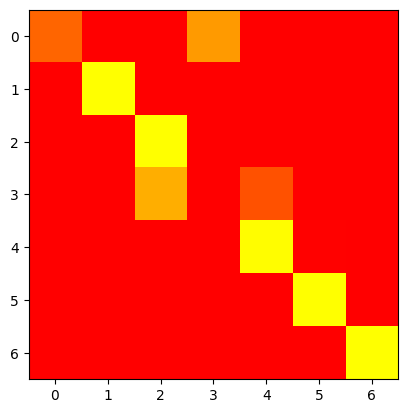

In [124]:
plt.imshow(model.emissionprob_, interpolation='none', cmap=colormaps["autumn"])
plt.show()

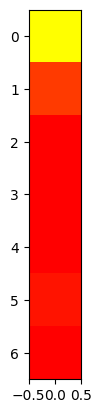

In [125]:
plt.imshow(np.array([model.startprob_]).reshape((7,1)), interpolation='none', cmap=colormaps["autumn"])
plt.show()

## Counting Laps

In [126]:
model.decode(np.array([[station_to_emission[detection["stationId"]] for detection in team_detections[1]]]))

(-28348.356369956804, array([0, 0, 0, ..., 4, 4, 4]))

In [127]:
start = time()

start_segment = list(model.startprob_).index(np.max(model.startprob_))
counts = []
half = 7//2

team_laps: dict[int, list[int]] = {}

for team in teams:
    _, path = model.decode(np.array([[station_to_emission[detection["stationId"]] for detection in team_detections[team["id"]]]]))
    count = 0
    prev = path[0]
    lap_times = []
    for i, segment in enumerate(path[1:]):
        delta = half - (half - (segment - prev)) % 7
        if delta > 0 and prev > segment:
            count += 1
            lap_times.append(team_detections[team["id"]][i+1]["timestamp"])
        elif delta < 0 and prev < segment:
            count -= 1
            if len(lap_times) > 0:
                lap_times.pop()
        prev = segment

    counts.append((team["name"], count))
    team_laps[team['id']] = lap_times

counts = sorted(counts, key=lambda x:x[1])

print(counts)
#print(team_laps)

labels = [l for l, _ in counts]
counts = [c for _, c in counts]

print(f'Took: {time() - start}')

[('HILOK', -876), ('VTK', -870), ('VLK', -775), ('VGK', -737), ('VEK - ML', -724), ('Wetenschappen', -667), ('HERMES - GFK', -649), ('Politeia', -640), ('VRG', -629), ('VPPK', -628), ('HK', -628), ('Blandinia', -622), ('HILOK Ladies', -616), ('SK', -589), ('Lombrosiana - VBK', -581), ('Lila - VDK', -557), ('Antilopen', -550)]
Took: 0.5454237461090088


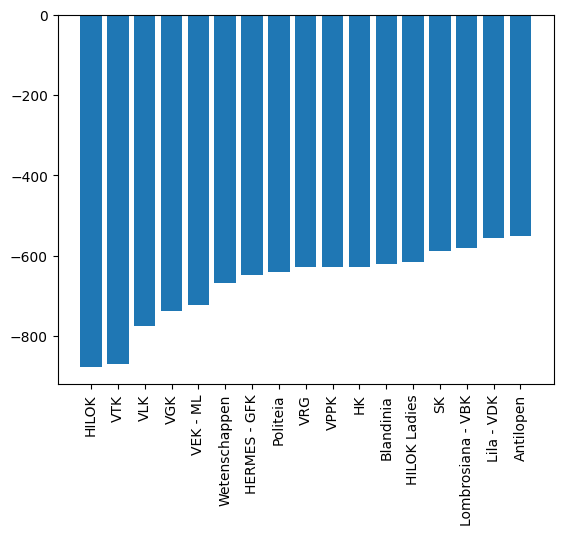

In [128]:
# Make a random dataset:
y_pos = np.arange(len(labels))

# Create bars
plt.bar(y_pos, counts)

# Create names on the x-axis
plt.xticks(y_pos, labels, rotation=90)

# Show graphic
plt.show()

# Interval Lapper

In [46]:
team_all_detections: dict[int, list] = {team["id"]: [] for team in teams}
team_by_id: dict[int, dict] = {team["id"]: team for team in teams}
baton_team: dict[int, dict] = {}

switchover_index = 0
for detection in detections:
    while switchover_index < len(baton_switchovers) and baton_switchovers[switchover_index]["timestamp"] < detection[
        "timestamp"]:
        switchover = baton_switchovers[switchover_index]
        baton_team[switchover["newBatonId"]] = team_by_id[switchover["teamId"]]
        switchover_index += 1

    if detection["batonId"] in baton_team:
        current_detections = team_all_detections[baton_team[detection["batonId"]]["id"]]
        current_detections.append(detection)



interval = 5000  # 10s
counts = []
half = 7//2

for team in teams:
    intervals = [[]]
    for detection in team_all_detections[team["id"]]:
        if len(intervals[-1]) == 0 or detection["timestamp"] < intervals[-1][0]["timestamp"] + interval:
            intervals[-1].append(detection)
        else:
            intervals.append([detection])

    path = []
    for group in intervals:
        station = Counter(map(lambda x: x["stationId"], group)).most_common(1)[0][0]
        path.append(station_to_emission[station])


    count = 0
    prev = path[0]
    lap_times = []
    for i, segment in enumerate(path[1:]):
        delta = half - (half - (segment - prev)) % 7
        if delta > 0 and prev > segment:
            count += 1
            #lap_times.append(team_detections[team["id"]][i+1]["timestamp"])
        elif delta < 0 and prev < segment:
            count -= 1
            #lap_times.pop()
        prev = segment

    counts.append((team["name"], count))

counts = sorted(counts, key=lambda x:x[1])

print(counts)

[('HILOK', -876), ('VTK', -860), ('VLK', -775), ('VEK - ML', -731), ('Wetenschappen', -668), ('HERMES - GFK', -649), ('Politeia', -634), ('VRG', -628), ('HK', -628), ('VPPK', -627), ('VGK', -625), ('Blandinia', -622), ('SK', -588), ('Lombrosiana - VBK', -580), ('Lila - VDK', -556), ('Antilopen', -553), ('HILOK Ladies', -309)]


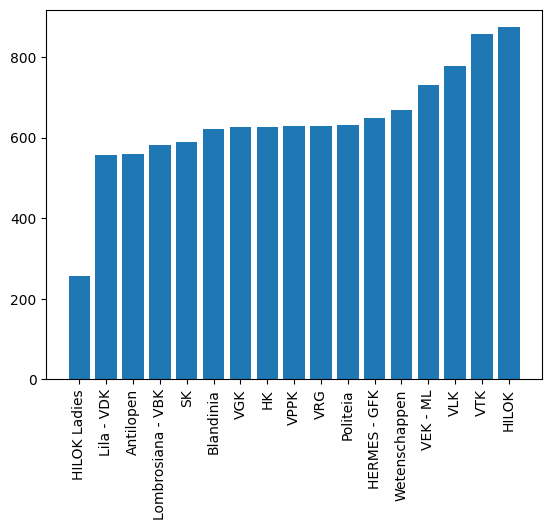

In [65]:


labels = [l for l, _ in counts]
counts = [c for _, c in counts]

# Make a random dataset:
y_pos = np.arange(len(labels))

# Create bars
plt.bar(y_pos, counts)

# Create names on the x-axis
plt.xticks(y_pos, labels, rotation=90)

# Show graphic
plt.show()

# Static Parameters visualisation

In [27]:
model = hmm.CategoricalHMM(n_components=7, n_iter=1000, init_params="s")
model.transmat_ = TRANSITION_PROBABILITIES_12UL.copy()
model.emissionprob_ = EMISSION_PROBABILITIES_12UL.copy()
model.startprob_ = START_PROBABILITIES_12UL.copy()

model.score(np_data, lengths)

-232136.70896702813

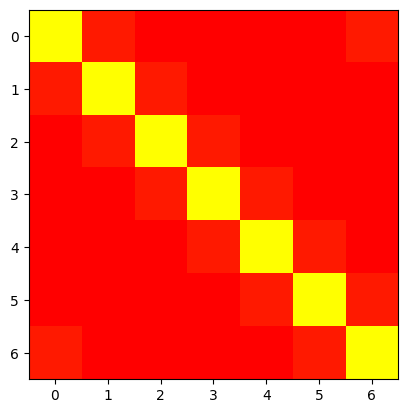

In [28]:
plt.imshow(model.transmat_, interpolation='none', cmap=colormaps["autumn"])
plt.show()

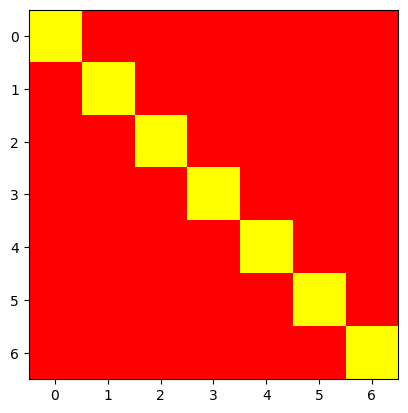

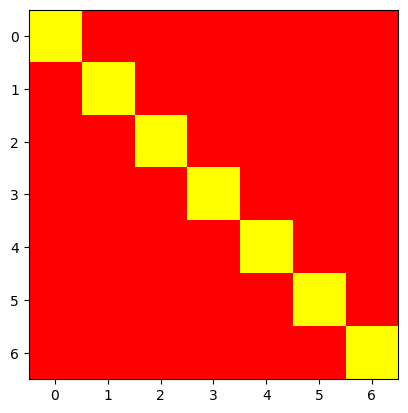

In [30]:
plt.imshow(model.emissionprob_, interpolation='none', cmap=colormaps["autumn"])
plt.show()

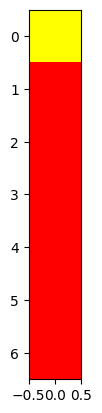

In [31]:
plt.imshow(np.array([model.startprob_]).reshape((7,1)), interpolation='none', cmap=colormaps["autumn"])
plt.show()

# Varia

In [139]:
urenloop_count = [{"count": 875, "team": {"id": 1, "name": "HILOK"}}, {"count": 777, "team": {"id": 3, "name": "VLK"}}, {"count": 669, "team": {"id": 4, "name": "Wetenschappen"}}, {"count": 629, "team": {"id": 5, "name": "VRG"}}, {"count": 649, "team": {"id": 8, "name": "HERMES - GFK"}}, {"count": 553, "team": {"id": 9, "name": "Lila - VDK"}}, {"count": 626, "team": {"id": 10, "name": "VPPK"}}, {"count": 730, "team": {"id": 11, "name": "VEK - ML"}}, {"count": 631, "team": {"id": 12, "name": "HK"}}, {"count": 565, "team": {"id": 13, "name": "Lombrosiana - VBK"}}, {"count": 622, "team": {"id": 14, "name": "Blandinia"}}, {"count": 528, "team": {"id": 17, "name": "Antilopen"}}, {"count": 642, "team": {"id": 7, "name": "Politeia"}}, {"count": 613, "team": {"id": 22, "name": "HILOK Ladies"}}, {"count": 740, "team": {"id": 6, "name": "VGK"}}, {"count": 868, "team": {"id": 2, "name": "VTK"}}, {"count": 577, "team": {"id": 16, "name": "SK"}}]

# eventual count with all sources addes
urenloop_count = {entry["team"]["name"]: entry["count"] for entry in urenloop_count}

# Only viterbi count - without manual data
# urenloop_count = {team["name"]: len([lap["timestamp"] for lap in laps if lap["teamId"] == team["id"] and lap["lapSourceId"] == 3]) for team in teams}

own_count = [('HILOK', -876), ('VTK', -870), ('VLK', -775), ('VGK', -737), ('VEK - ML', -724), ('Wetenschappen', -667), ('HERMES - GFK', -649), ('Politeia', -640), ('VRG', -629), ('VPPK', -628), ('HK', -628), ('Blandinia', -622), ('HILOK Ladies', -616), ('SK', -589), ('Lombrosiana - VBK', -581), ('Lila - VDK', -557), ('Antilopen', -550)]

own_count = {entry[0]: -entry[1] for entry in own_count}

diff = {k: v-urenloop_count[k] for k, v in own_count.items()}
diff

{'HILOK': 1,
 'VTK': 2,
 'VLK': -2,
 'VGK': -3,
 'VEK - ML': -6,
 'Wetenschappen': -2,
 'HERMES - GFK': 0,
 'Politeia': -2,
 'VRG': 0,
 'VPPK': 2,
 'HK': -3,
 'Blandinia': 0,
 'HILOK Ladies': 3,
 'SK': 12,
 'Lombrosiana - VBK': 16,
 'Lila - VDK': 4,
 'Antilopen': 22}

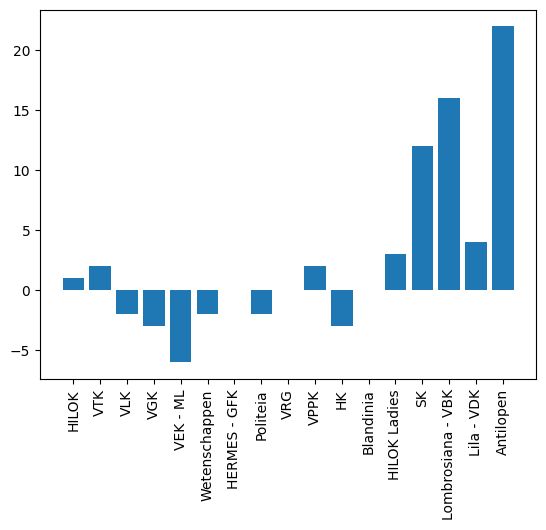

In [140]:
# Make a random dataset:
y_pos = np.arange(len(labels))

# Create bars
plt.bar(y_pos, diff.values())

# Create names on the x-axis
plt.xticks(y_pos, diff.keys(), rotation=90)

# Show graphic
plt.show()

# Varia

In [138]:
urenloop_count = [{"count": 875, "team": {"id": 1, "name": "HILOK"}}, {"count": 777, "team": {"id": 3, "name": "VLK"}}, {"count": 669, "team": {"id": 4, "name": "Wetenschappen"}}, {"count": 629, "team": {"id": 5, "name": "VRG"}}, {"count": 649, "team": {"id": 8, "name": "HERMES - GFK"}}, {"count": 553, "team": {"id": 9, "name": "Lila - VDK"}}, {"count": 626, "team": {"id": 10, "name": "VPPK"}}, {"count": 730, "team": {"id": 11, "name": "VEK - ML"}}, {"count": 631, "team": {"id": 12, "name": "HK"}}, {"count": 565, "team": {"id": 13, "name": "Lombrosiana - VBK"}}, {"count": 622, "team": {"id": 14, "name": "Blandinia"}}, {"count": 528, "team": {"id": 17, "name": "Antilopen"}}, {"count": 642, "team": {"id": 7, "name": "Politeia"}}, {"count": 613, "team": {"id": 22, "name": "HILOK Ladies"}}, {"count": 740, "team": {"id": 6, "name": "VGK"}}, {"count": 868, "team": {"id": 2, "name": "VTK"}}, {"count": 577, "team": {"id": 16, "name": "SK"}}]

# eventual count with all sources addes
#urenloop_count = {entry["team"]["name"]: entry["count"] for entry in urenloop_count}

# Only viterbi count - without manual data
urenloop_count = {team["name"]: len([lap["timestamp"] for lap in laps if lap["teamId"] == team["id"] and lap["lapSourceId"] == 3]) for team in teams}

own_count = [('Antilopen', 522), ('Lila - VDK', 542), ('Lombrosiana - VBK', 568), ('SK', 580), ('HILOK Ladies', 613), ('Blandinia', 618), ('VPPK', 621), ('VRG', 622), ('Politeia', 627), ('HK', 628), ('HERMES - GFK', 649), ('Wetenschappen', 662), ('VGK', 685), ('VEK - ML', 707), ('VLK', 764), ('VTK', 864), ('HILOK', 873)]

own_count = {entry[0]: entry[1] for entry in own_count}

diff = {k: v-urenloop_count[k] for k, v in own_count.items()}
diff

{'Antilopen': 522,
 'Lila - VDK': 542,
 'Lombrosiana - VBK': 568,
 'SK': 580,
 'HILOK Ladies': 35,
 'Blandinia': 618,
 'VPPK': 621,
 'VRG': 622,
 'Politeia': 627,
 'HK': 628,
 'HERMES - GFK': 649,
 'Wetenschappen': 662,
 'VGK': 685,
 'VEK - ML': 707,
 'VLK': 764,
 'VTK': 864,
 'HILOK': 873}

In [34]:
# Make a random dataset:
y_pos = np.arange(len(labels))

# Create bars
plt.bar(y_pos, diff.values())

# Create names on the x-axis
plt.xticks(y_pos, diff.keys(), rotation=90)

# Show graphic
plt.show()

692


In [35]:
i = 6
relative_laptimes = []
prev = team_laps[i][0]
for time in team_laps[i][1:]:
    relative_laptimes.append((time-prev)/1000)
    prev = time

plt.figure(figsize=(20, 4))
plt.plot(np.array(relative_laptimes))
plt.show()

lapss = [lap["timestamp"] for lap in laps if lap["teamId"] == i and lap["lapSourceId"] == 3]

relative_laptimes = []
prev = lapss[0]
for time in lapss[1:]:
    relative_laptimes.append((time-prev)/1000)
    prev = time

plt.figure(figsize=(20, 4))
plt.plot(np.array(relative_laptimes))
plt.show()

[{'id': 1, 'name': 'HILOK', 'batonId': 18},
 {'id': 3, 'name': 'VLK', 'batonId': 12},
 {'id': 4, 'name': 'Wetenschappen', 'batonId': 6},
 {'id': 5, 'name': 'VRG', 'batonId': 9},
 {'id': 8, 'name': 'HERMES - GFK', 'batonId': 10},
 {'id': 9, 'name': 'Lila - VDK', 'batonId': 21},
 {'id': 10, 'name': 'VPPK', 'batonId': 19},
 {'id': 11, 'name': 'VEK - ML', 'batonId': 7},
 {'id': 12, 'name': 'HK', 'batonId': 13},
 {'id': 13, 'name': 'Lombrosiana - VBK', 'batonId': 2},
 {'id': 14, 'name': 'Blandinia', 'batonId': 4},
 {'id': 17, 'name': 'Antilopen', 'batonId': 16},
 {'id': 7, 'name': 'Politeia', 'batonId': 3},
 {'id': 22, 'name': 'HILOK Ladies', 'batonId': 8},
 {'id': 6, 'name': 'VGK', 'batonId': 17},
 {'id': 2, 'name': 'VTK', 'batonId': 15},
 {'id': 16, 'name': 'SK', 'batonId': 22}]

In [109]:
print(len([lap["timestamp"] for lap in laps if lap["teamId"] == 6 and lap["lapSourceId"] == 1]))

48


In [131]:
print(len([lap["timestamp"] for lap in laps if lap["teamId"] == 6 and lap["lapSourceId"] == 3]))

692


In [48]:
teams

[{'id': 1, 'name': 'HILOK', 'batonId': 18},
 {'id': 3, 'name': 'VLK', 'batonId': 12},
 {'id': 4, 'name': 'Wetenschappen', 'batonId': 6},
 {'id': 5, 'name': 'VRG', 'batonId': 9},
 {'id': 8, 'name': 'HERMES - GFK', 'batonId': 10},
 {'id': 9, 'name': 'Lila - VDK', 'batonId': 21},
 {'id': 10, 'name': 'VPPK', 'batonId': 19},
 {'id': 11, 'name': 'VEK - ML', 'batonId': 7},
 {'id': 12, 'name': 'HK', 'batonId': 13},
 {'id': 13, 'name': 'Lombrosiana - VBK', 'batonId': 2},
 {'id': 14, 'name': 'Blandinia', 'batonId': 4},
 {'id': 17, 'name': 'Antilopen', 'batonId': 16},
 {'id': 7, 'name': 'Politeia', 'batonId': 3},
 {'id': 22, 'name': 'HILOK Ladies', 'batonId': 8},
 {'id': 6, 'name': 'VGK', 'batonId': 17},
 {'id': 2, 'name': 'VTK', 'batonId': 15},
 {'id': 16, 'name': 'SK', 'batonId': 22}]

In [120]:
plt.figure(figsize=(4, 4))

for station in sorted(stations, key=lambda x: x["id"]):
    plt.plot(
        [detection["timestamp"] for detection in team_detections[6] if detection["stationId"] == station["id"]],
        [detection["rssi"] for detection in team_detections[6] if detection["stationId"] == station["id"]],
        'o', label=station["name"]
    )

plt.legend()
plt.show()

<IPython.core.display.Javascript object>